# Pet Breed Classification

In this example, we’ll build an image classifier to detect the 37
different dog and cat breeds in the [Oxford-IIIT Pet
Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). This is a [well
studied](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb)
example, so our main purpose here will be to illustrate its solution
using Pytorch Lightning and
[Torchmetrics](https://torchmetrics.readthedocs.io/en/stable/pages/quickstart.html).

Torchmetrics is a new library that has many metrics for classification
in Pytorch.

-   It allows for easy computation over batches.
-   Rigorously tested.
-   A standardized interface to increase reproduciblity.
-   And much more…

We’ll install it below with Pytorch Lightning.

In [2]:
!pip install pytorch-lightning
!pip install lightning-bolts
!pip install seaborn
!pip install watermark

In [4]:
import os
import torch
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pytorch_lightning import LightningModule, Trainer, seed_everything
from pl_bolts.transforms.dataset_normalizations import imagenet_normalization
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

seed_everything(7)

Global seed set to 7

7

Let’s quickly load and visualize the dataset. A more thorough inspection
can be done using [Voxel
51](https://voxel51.com/docs/fiftyone/index.html).

In [3]:
# Set download=False after download is complete.
vis_dataset = torchvision.datasets.OxfordIIITPet(root="./data",split="trainval",download=True)

Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet
Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet

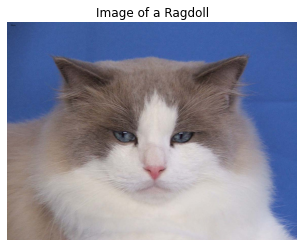

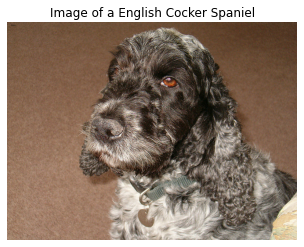

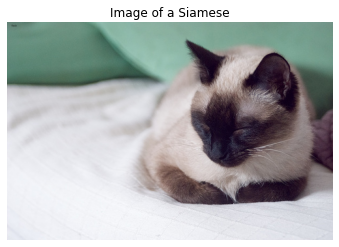

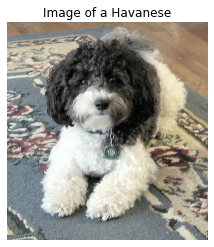

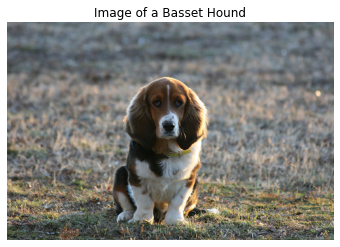

In [4]:
for i in range(5):
    image, label = vis_dataset[random.choice(range(len(vis_dataset)))]
    
    fig = plt.figure()
    plt.imshow(image)
    plt.title(f"Image of a {vis_dataset.classes[label]}")
    plt.axis("off")

Now let’s make transforms for the training, validation, and test set.
We’ll use `torchvision`s `RandAugment` which is an automated data
augmentation strategy that improves the classifier accuracy by a few
percentage points.

Also since we’ll be using a ResNet model pretrained on ImageNet, we’ll
also use ImageNet normalization.

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.RandAugment(),
    transforms.ToTensor(),
    imagenet_normalization()
])
val_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    imagenet_normalization()
])

Most of the remaining steps are fairly standard for obtaining a fixed
train/val/test dataset. Note that the split is fixed since we used
`seed_everything` earlier.

In [6]:
train_dataset = torchvision.datasets.OxfordIIITPet(root="./data", split="trainval", transform=train_transform, download=False)
test_dataset = torchvision.datasets.OxfordIIITPet(root="./data", split="test",transform=val_transform, download=False)

In [7]:
classes = train_dataset.classes
num_classes = len(classes)
BATCH_SIZE = 32

In [8]:
split_len = int(0.9*len(train_dataset))
train_dataset, val_dataset = random_split(train_dataset, [split_len, len(train_dataset)-split_len], generator=torch.Generator().manual_seed(7))

In [9]:
print('Length of train dataset: ', len(train_dataset))
print('Length of validation dataset: ', len(val_dataset))
print('Length of test dataset: ', len(test_dataset))

Length of train dataset:  3312
Length of validation dataset:  368
Length of test dataset:  3669

In [10]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=os.cpu_count())
val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=os.cpu_count())
test_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=os.cpu_count())

Let’s take a look at the class statistics in the train dataset.

In [11]:
class_counts = np.array([0]*num_classes)

for batch in train_dataloader:
    _, labels = batch
    
    for label in labels:
        class_counts[label] += 1
        
df_classes = pd.DataFrame({"classes" : classes, "class_counts" : class_counts})

As we’ll see the classes are balanced, which simplifies the treatment of
this problem.

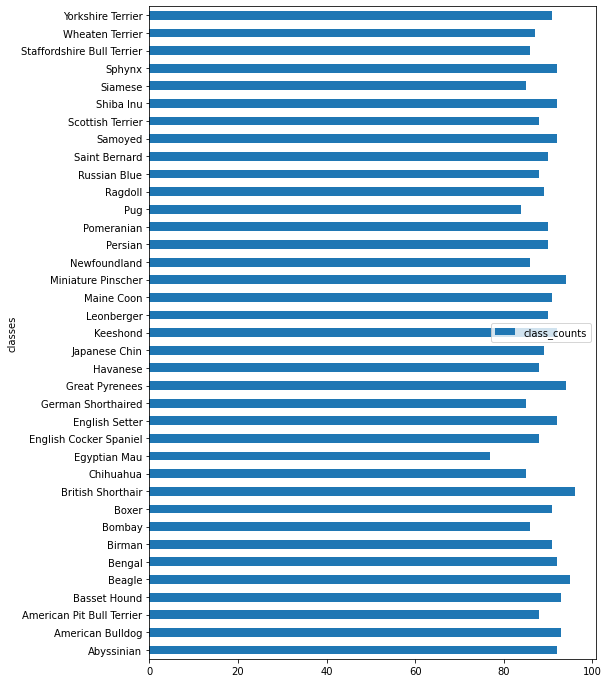

In [12]:
df_classes.plot(kind="barh", x="classes", y="class_counts",figsize=(8,12))
plt.show()

Now we’ll write the Pytorch Lightning module to create and train the
model.

To train our model, we’ll freeze pretrained models from torchvision and
add a linear head for fine tuning. For illustrative purposes, we’ll use
a ResNet34 model, but you can also try ResNext50, or RegNetX to obtain
slightly higher accuracy. The model will be set as the `model` attribute
in the LightningModule class.

Since the LightningModule inherits from the Pytorch Module, we also have
to set the `forward` method of the neural network. The `backward` method
is automatically generated.

The training is relatively simple, using an Adam optimizer, which is set
in the `configure_optimizers` method.

The training, validation, and test steps for a batch of data are
configured via the `training_step`, `validation_step`, and `test_step`
respectively. We’ll use a single custom method called `evaluate` to
handle the validation and test steps. See the Lightning documentation
for more details.

Finally, we’ll use Accuracy and F1Score with `torchmetrics` to measure
the performance of our model.

-   Since we’re using the object oriented API, which preserves state, we
    have to create separate objects for the train, val and test sets.
-   We wrap `Accuracy` and `F1Score` in the `MetricCollection`, which
    will automatically share common computations between the two
    metrics, and simplify the code.
-   For multiclass classifiers, the average option passed to the metrics
    (**micro** or **macro**) affects the calculation. The choices below
    were chosen to be consistent with scikit-learn, and work well with a
    balanaced dataset. I’ll delve deeper into these nuances in following
    posts.

In [41]:
import torch.nn as nn
from torchmetrics import MetricCollection, Accuracy, F1Score
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
from torchvision.models import regnet_x_3_2gf, RegNet_X_3_2GF_Weights

class PetModel(LightningModule):
    
    def __init__(self, arch, learning_rate, num_classes):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.zeros((BATCH_SIZE, 3, 224,224))
        
        # Setup the model.
        self.create_model(arch)
        
        # Setup the losses.
        self.loss = nn.CrossEntropyLoss()
        
        # Setup the metrics.
        self.train_metrics = MetricCollection({"train_acc" : Accuracy(num_classes=num_classes, average="micro"),
                                               "train_f1" : F1Score(num_classes=num_classes, average="macro")})
        self.val_metrics = MetricCollection({"val_acc" : Accuracy(num_classes=num_classes, average="micro"),
                                               "val_f1" : F1Score(num_classes=num_classes, average="macro")})
        self.test_metrics = MetricCollection({"test_acc" : Accuracy(num_classes=num_classes, average="micro"),
                                               "test_f1" : F1Score(num_classes=num_classes, average="macro")})
        
    def create_model(self, arch):
      """
        Setup a model for fine tuning.
      """
      in_dimension = 512
      if arch == "resnext50_32x4d":
        self.model = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT)
        in_dimension = 4*512
      elif arch == "regnet_x_3_2gf":
        self.model = regnet_x_3_2gf(weights=RegNet_X_3_2GF_Weights.DEFAULT)
        in_dimension = 1008
      else:
        self.model = resnet34(weights=ResNet34_Weights.DEFAULT)

        in_dimension = 512

      for param in self.model.parameters():
        param.requires_grad = False

      self.model.fc = nn.Linear(in_dimension, num_classes)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        images, labels = batch
        
        logits = self(images)
        preds = torch.argmax(logits, dim=1)
        loss = self.loss(logits, labels)
        
        self.train_metrics(preds, labels)
        
        self.log("train_acc", self.train_metrics["train_acc"], prog_bar=True)
        self.log("train_f1", self.train_metrics["train_f1"], prog_bar=True)        
        self.log("train_loss", loss, prog_bar=True)        
        
        return loss
    
    def evaluate(self, batch, stage=None):
        images, labels = batch
        
        logits = self(images)
        preds = torch.argmax(logits, dim=1)
        loss = nn.CrossEntropyLoss()(logits, labels)
        
        if stage == "val":
            self.val_metrics(preds,labels)
            
            self.log("val_acc", self.val_metrics["val_acc"], prog_bar=True)
            self.log("val_f1", self.val_metrics["val_f1"], prog_bar=True)        
            self.log("val_loss", loss, prog_bar=True)  
        elif stage == "test":
            self.test_metrics(preds,labels)
            
            self.log("test_acc", self.test_metrics["test_acc"], prog_bar=True)
            self.log("test_f1", self.test_metrics["test_f1"], prog_bar=True)        
            self.log("test_loss", loss, prog_bar=True)  
            
    def validation_step(self, batch, batch_idx):
        return self.evaluate(batch, "val")
    
    def test_step(self, batch, batch_idx):
        return self.evaluate(batch, "test")
    
    def configure_optimizers(self):
        return torch.optim.Adam(params=self.parameters(), lr=self.hparams.learning_rate)

In [42]:
model = PetModel("resnet34", 1e-3, num_classes)

We’ll log metrics to TensorBoard using the `TensorBoardLogger`, and save
the best model, measured using accuracy, with the `ModelCheckpoint`.

In [43]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

name = "oxfordpet" + "_" + model.hparams.arch
logger = TensorBoardLogger(save_dir="lightning_logs",
                           name=name,
                           log_graph=True,
                           default_hp_metric=False)
callbacks = [ModelCheckpoint(monitor="val_acc",save_top_k=1, mode="max") ]

Initialize the trainer by requiring training to be done on the GPU, max
epochs of 12, setting the logger, and callbacks.

In [45]:
trainer = Trainer(accelerator='gpu', 
                  devices=1,
                  max_epochs=12,
                  logger=logger,
                  callbacks=callbacks,
                  fast_dev_run=False)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs

Visualize training progress in TesnorBoard.

In [46]:
%load_ext tensorboard
%tensorboard --logdir=./lightning_logs --bind_all

Finally, fit the model on the training dataset while saving the best
model based on performance on the validation dataset.

In [47]:
trainer.fit(model, 
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params | In sizes          | Out sizes
-----------------------------------------------------------------------------------
0 | model         | ResNet           | 21.3 M | [32, 3, 224, 224] | [32, 37] 
1 | loss          | CrossEntropyLoss | 0      | ?                 | ?        
2 | train_metrics | MetricCollection | 0      | ?                 | ?        
3 | val_metrics   | MetricCollection | 0      | ?                 | ?        
4 | test_metrics  | MetricCollection | 0      | ?                 | ?        
-----------------------------------------------------------------------------------
19.0 K    Trainable params
21.3 M    Non-trainable params
21.3 M    Total params
85.215    Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=12` reached.

Let’s load the best model and measure its performance.

In [48]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)

lightning_logs/oxfordpet_resnet34/version_0/checkpoints/epoch=7-step=832.ckpt

In [49]:
best_model = PetModel.load_from_checkpoint(checkpoint_path=best_model_path)

In [50]:
trainer.test(best_model,dataloaders=test_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8396739363670349
         test_f1            0.8321808576583862
        test_loss           0.4552876353263855
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[{'test_acc': 0.8396739363670349,
  'test_f1': 0.8321808576583862,
  'test_loss': 0.4552876353263855}]

Now visualize the confusion matrix.

In [51]:
from torchmetrics import ConfusionMatrix

confmat = ConfusionMatrix(num_classes=num_classes, normalize='true')
prev_device = best_model.device.type
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

confmat.to(device)
best_model.to(device)
with torch.no_grad():
    best_model.eval()
    
    for batch in test_dataloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        logits = best_model(images)
        preds = torch.argmax(logits, dim=1)

        confmat.update(preds, labels)
    
best_model.to(prev_device)
1

1

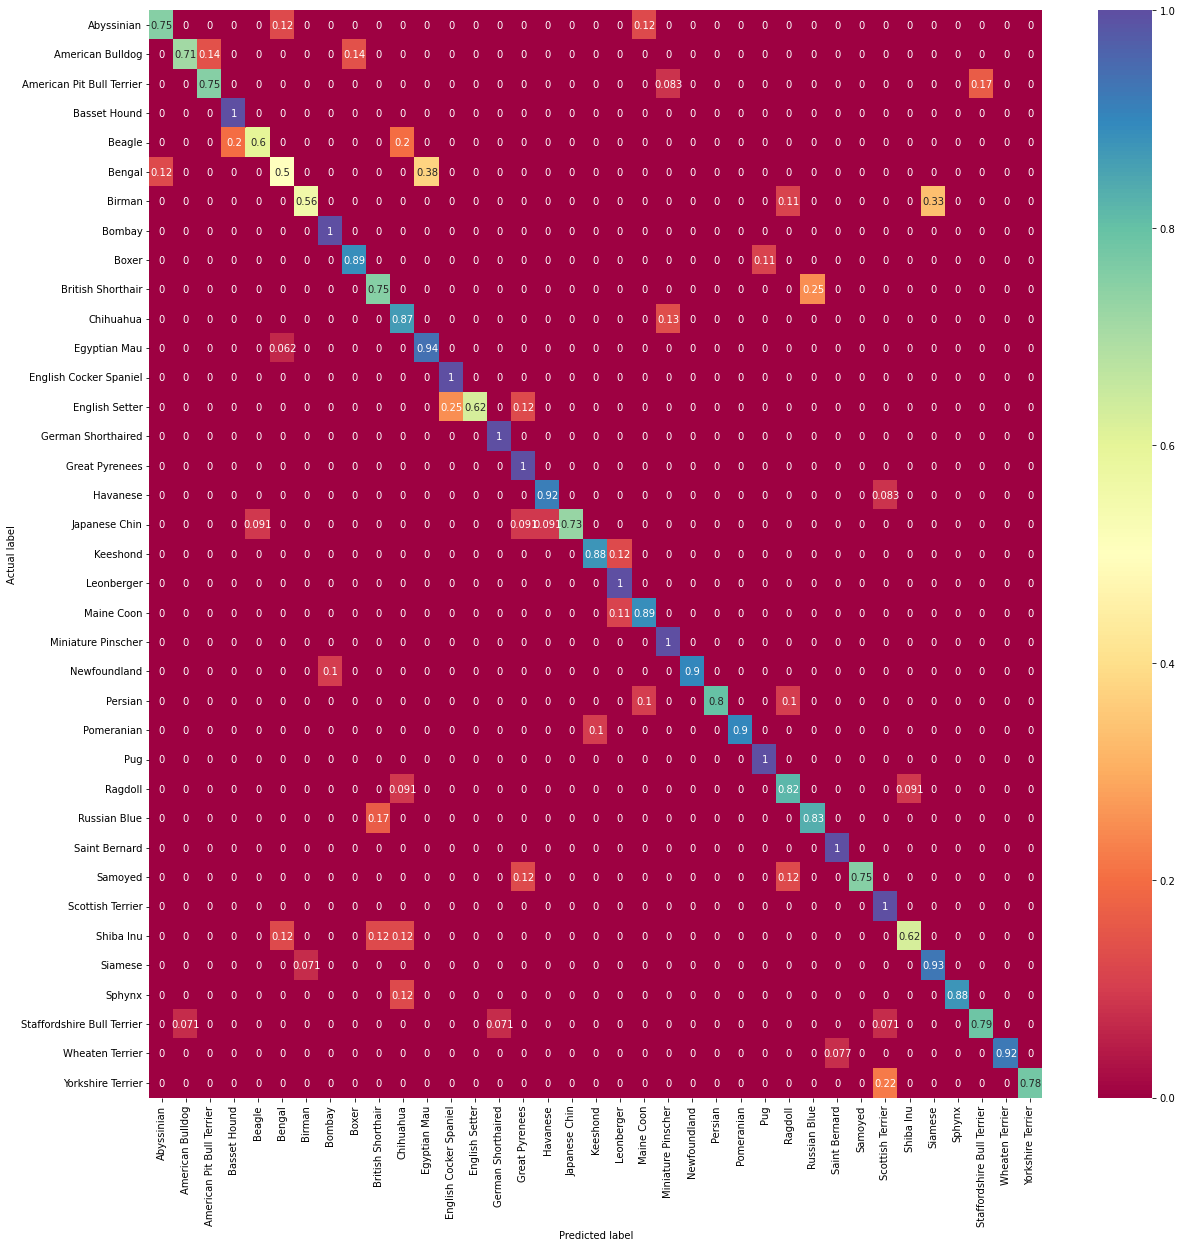

In [52]:
import seaborn as sns
cmat = confmat.compute().cpu().numpy()

fig, ax = plt.subplots(figsize=(20,20))

df_cm = pd.DataFrame(cmat, index = range(len(classes)), columns=range(len(classes)))
ax = sns.heatmap(df_cm, annot=True, fmt='.2g', cmap='Spectral')
ax.set_yticklabels([classes[i] for i in range(len(classes))], rotation=0)
ax.set_xticklabels([classes[i] for i in range(len(classes))], rotation=90)
ax.set_xlabel("Predicted label")
ax.set_ylabel("Actual label")
plt.show(block=False)

In [9]:
%load_ext watermark
%watermark --iversions -v

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.31.0

torchvision: 0.13.0
matplotlib : 3.5.1
torch      : 1.12.0
pandas     : 1.3.5
numpy      : 1.19.5
